# compare Run 6 results with BOT Run 5

In [18]:
import numpy as np
import pandas as pd
import scipy as sp
import sys
import copy
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate


from lsst.obs.lsst import LsstCam, LsstTS8
import lsst.eo.pipe as eo_pipe

from myutils import *

from lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask,
                          eperTask, divisaderoTearingTask, ptcPlotsTask,
                          linearityPlotsTask, bfAnalysisTask)



# Code 

def eopipe_DictToDfz(amp_data):
    """ convert summary data from amp_data to a dataframe    
    """
    
    # some prep
    rtmtypes = get_allrtmtype()
    cornerbays = get_crtms()
    
    # here are all the data keys
    datakeys = amp_data.keys()
        
    # get set of bayslot's present in any of the keys
    bayslot_set = {}
    for akey in datakeys:
        keyset = amp_data[akey]
        for bayslot in keyset:
            if type(bayslot)==int:
                print(akey,bayslot)
            #if len(bayslot)!=7:
            #    print(akey,bayslot)
        bayslot_set =  bayslot_set | amp_data[akey].keys()
    print(bayslot_set)
    bayslot_list = sorted(list(bayslot_set))
        
    # output dictionary
    cdf = {}

    # fill lists of the data
    for akey in datakeys:
        cdf[akey] = []        
        for bayslot in bayslot_list:            
            seglist = bayslot_segments(bayslot)
            for seg in seglist:
                if bayslot in amp_data[akey]:
                    try:
                        cdf[akey].append(amp_data[akey][bayslot][seg])
                    except:
                        cdf[akey].append(np.nan)
                        #print(akey,bayslot,seg)
                else:
                    cdf[akey].append(np.nan)

    # fill lists with bay,slot,segment for the data
    allbay = []
    allslot = []
    allbayslot = []
    allamp = []      # 1 to 16 amp numbering
    allbaytype = []  # S or C
    allrtmtype = []  # itl or e2v
    allsegment = []  # Cxx 
    for bayslot in bayslot_list:
        seglist = bayslot_segments(bayslot)
        for i,seg in enumerate(seglist):
            allbayslot.append(bayslot)
            allbay.append(bayslot[0:3])
            allslot.append(bayslot[4:])
            allamp.append(i)
            allsegment.append(seg)
            allrtmtype.append(rtmtypes[bayslot[0:3]])
            if bayslot[0:4] in cornerbays:
                allbaytype.append('C')
            else:
                allbaytype.append('S')
            
            
    # add to DF with ccd info
    cdf['BAY'] = allbay
    cdf['SLOT'] = allslot
    cdf['AMP'] = allamp
    cdf['BAYTYPE'] = allbaytype
    cdf['BAY_SLOT'] = allbayslot
    cdf['SEGMENT'] = allsegment
            
        
    # fill 
    df = pd.DataFrame(cdf)
    df.columns = df.columns.str.upper()
    return df

In [19]:
def compare_tworuns(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True,legend_loc='lower right',scale='linear'):

    rtms = get_rtms()
    crtms = get_crtms()
    rtmids = get_rtmids()
    allrtms = rtms + crtms

    f,ax = plt.subplots(5,5,figsize=(22,22),constrained_layout=True)
    axf = ax

    for i,abay in enumerate(allrtms):

        thertm = rtmids[abay]
        ix = 4-int(abay[1:2])
        iy = int(abay[2:3])

        # get the desired quantity, filtered by raft
        df1f = df1[df1.BAY==abay]
        df2f = df2[df2.BAY==abay]

        for aslot in get_slots_per_bay(abay):

            # filter by slot
            df1fs = df1f[df1f.SLOT==aslot]
            df2fs = df2f[df2f.SLOT==aslot]

            quant1 = df1fs[quantity]
            quant2 = df2fs[quantity]

            # make sure we have entries
            if len(quant1)>0 and len(quant1)==len(quant2):
                axf[ix,iy].scatter(quant1,quant2,label=aslot)


        axf[ix,iy].text(0.07,0.9,'%s %s' % (abay,thertm),transform=axf[ix,iy].transAxes)
        axf[ix,iy].set_xlabel('%s Run %s' % (quantity,run1))
        axf[ix,iy].set_ylabel('%s Run %s' % (quantity,run2))

        axf[ix,iy].set_xlim(minxy,maxxy)
        axf[ix,iy].set_ylim(minxy,maxxy)

        ax[ix,iy].set_xscale(scale)
        ax[ix,iy].set_yscale(scale)

        if (ix==0 and iy==0) or (ix==0 and iy==1):
            axf[ix,iy].legend(loc=legend_loc)

        if draw_line:
            line = lines.Line2D([minxy,maxxy], [minxy,maxxy], lw=2., color='r', alpha=0.4)
            axf[ix,iy].add_line(line)


# Get Read Noise and Dark Current data

## Run 13370 with Read Noise

In [5]:
# Run 6 data
runnum = 13370
weekly = 24
repo = '/repo/ir2'

names = ['u/lsstccs/eo_read_noise_no_ptc_%d_w_2023_%d'%(runnum,weekly)]
print(names)

collections = [aname for aname in names]

amp_data = {}
amp_data.update(readNoiseTask.get_amp_data(repo, collections))

['u/lsstccs/eo_read_noise_no_ptc_13370_w_2023_24']


In [12]:
df_13370 = eopipe_DictToDfz(amp_data)

{'R24_S01', 'R42_S22', 'R22_S02', 'R00_SW0', 'R11_S11', 'R41_S00', 'R23_S02', 'R04_SW1', 'R03_S12', 'R14_S21', 'R23_S22', 'R20_S22', 'R14_S11', 'R22_S22', 'R40_SG1', 'R34_S00', 'R22_S11', 'R40_SW0', 'R12_S01', 'R10_S10', 'R34_S02', 'R11_S01', 'R03_S21', 'R20_S01', 'R01_S01', 'R41_S11', 'R12_S22', 'R40_SW1', 'R31_S21', 'R33_S11', 'R11_S22', 'R11_S20', 'R34_S01', 'R44_SG1', 'R13_S01', 'R22_S01', 'R22_S10', 'R10_S01', 'R02_S20', 'R00_SG0', 'R24_S00', 'R11_S02', 'R30_S12', 'R33_S20', 'R43_S00', 'R32_S11', 'R41_S02', 'R13_S20', 'R02_S12', 'R24_S12', 'R01_S12', 'R13_S12', 'R22_S21', 'R03_S01', 'R44_SW1', 'R20_S20', 'R43_S22', 'R33_S10', 'R20_S12', 'R24_S10', 'R34_S20', 'R03_S02', 'R21_S01', 'R34_S21', 'R22_S00', 'R14_S20', 'R12_S21', 'R14_S12', 'R02_S21', 'R30_S01', 'R42_S00', 'R00_SG1', 'R40_SG0', 'R14_S10', 'R20_S21', 'R32_S22', 'R21_S10', 'R24_S22', 'R41_S22', 'R00_SW1', 'R41_S10', 'R43_S20', 'R13_S22', 'R24_S20', 'R42_S01', 'R13_S10', 'R10_S02', 'R23_S10', 'R43_S10', 'R32_S01', 'R30_S11'

In [21]:
print(df_13370.columns)

Index(['READ_NOISE', 'BAY', 'SLOT', 'AMP', 'BAYTYPE', 'BAY_SLOT', 'SEGMENT'], dtype='object')


## Dark Current from 13371

In [56]:
# Run 6 data
runnum = 13371
weekly = 24
repo = '/repo/ir2'

names = ['u/lsstccs/eo_dark_current_%d_w_2023_%d'%(runnum,weekly)]
print(names)

collections = [aname for aname in names]

amp_data_13371 = {}
amp_data_13371.update(readNoiseTask.get_amp_data(repo, collections))
amp_data_13371.update(darkCurrentTask.get_amp_data(repo, collections))

df_13371 = eopipe_DictToDfz(amp_data_13371)

print(df_13371.columns)

['u/lsstccs/eo_dark_current_13371_w_2023_24']
{'R24_S01', 'R42_S22', 'R22_S02', 'R11_S11', 'R41_S00', 'R23_S02', 'R00_SW0', 'R04_SW1', 'R03_S12', 'R14_S21', 'R20_S22', 'R23_S22', 'R14_S11', 'R22_S22', 'R40_SG1', 'R34_S00', 'R22_S11', 'R40_SW0', 'R12_S01', 'R10_S10', 'R11_S01', 'R34_S02', 'R03_S21', 'R20_S01', 'R01_S01', 'R41_S11', 'R12_S22', 'R40_SW1', 'R31_S21', 'R11_S22', 'R11_S20', 'R33_S11', 'R34_S01', 'R44_SG1', 'R13_S01', 'R22_S01', 'R22_S10', 'R10_S01', 'R02_S20', 'R00_SG0', 'R24_S00', 'R11_S02', 'R30_S12', 'R33_S20', 'R43_S00', 'R32_S11', 'R41_S02', 'R13_S20', 'R02_S12', 'R01_S12', 'R13_S12', 'R24_S12', 'R22_S21', 'R03_S01', 'R44_SW1', 'R20_S20', 'R43_S22', 'R33_S10', 'R20_S12', 'R24_S10', 'R03_S02', 'R34_S20', 'R21_S01', 'R22_S00', 'R34_S21', 'R14_S20', 'R12_S21', 'R14_S12', 'R02_S21', 'R30_S01', 'R32_S22', 'R20_S21', 'R42_S00', 'R14_S10', 'R00_SG1', 'R40_SG0', 'R21_S10', 'R24_S22', 'R41_S22', 'R00_SW1', 'R41_S10', 'R43_S20', 'R13_S22', 'R24_S20', 'R42_S01', 'R13_S10', 'R10_S0

## Run 5 data from 13162 and 13144

In [7]:

df_run5 = pd.read_parquet('df_13144_13162_w_2023_22.parquet')
print(df_run5.columns)


Index(['READ_NOISE', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


In [13]:
# merge the DataFrames
df_merge = df_13370.merge(df_run5,how='outer',on=['BAY_SLOT','SEGMENT'],suffixes=('','_RUN5'))

In [15]:
# note that most variables are from Run5, only one with changed name is the ones that are in both DataFrames
print(df_merge.columns)

Index(['READ_NOISE', 'BAY', 'SLOT', 'AMP', 'BAYTYPE', 'BAY_SLOT', 'SEGMENT',
       'READ_NOISE_RUN5', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY_RUN5', 'SLOT_RUN5',
       'AMP_RUN5', 'BAYTYPE_RUN5'],
      dtype='object')


# Comparison histograms

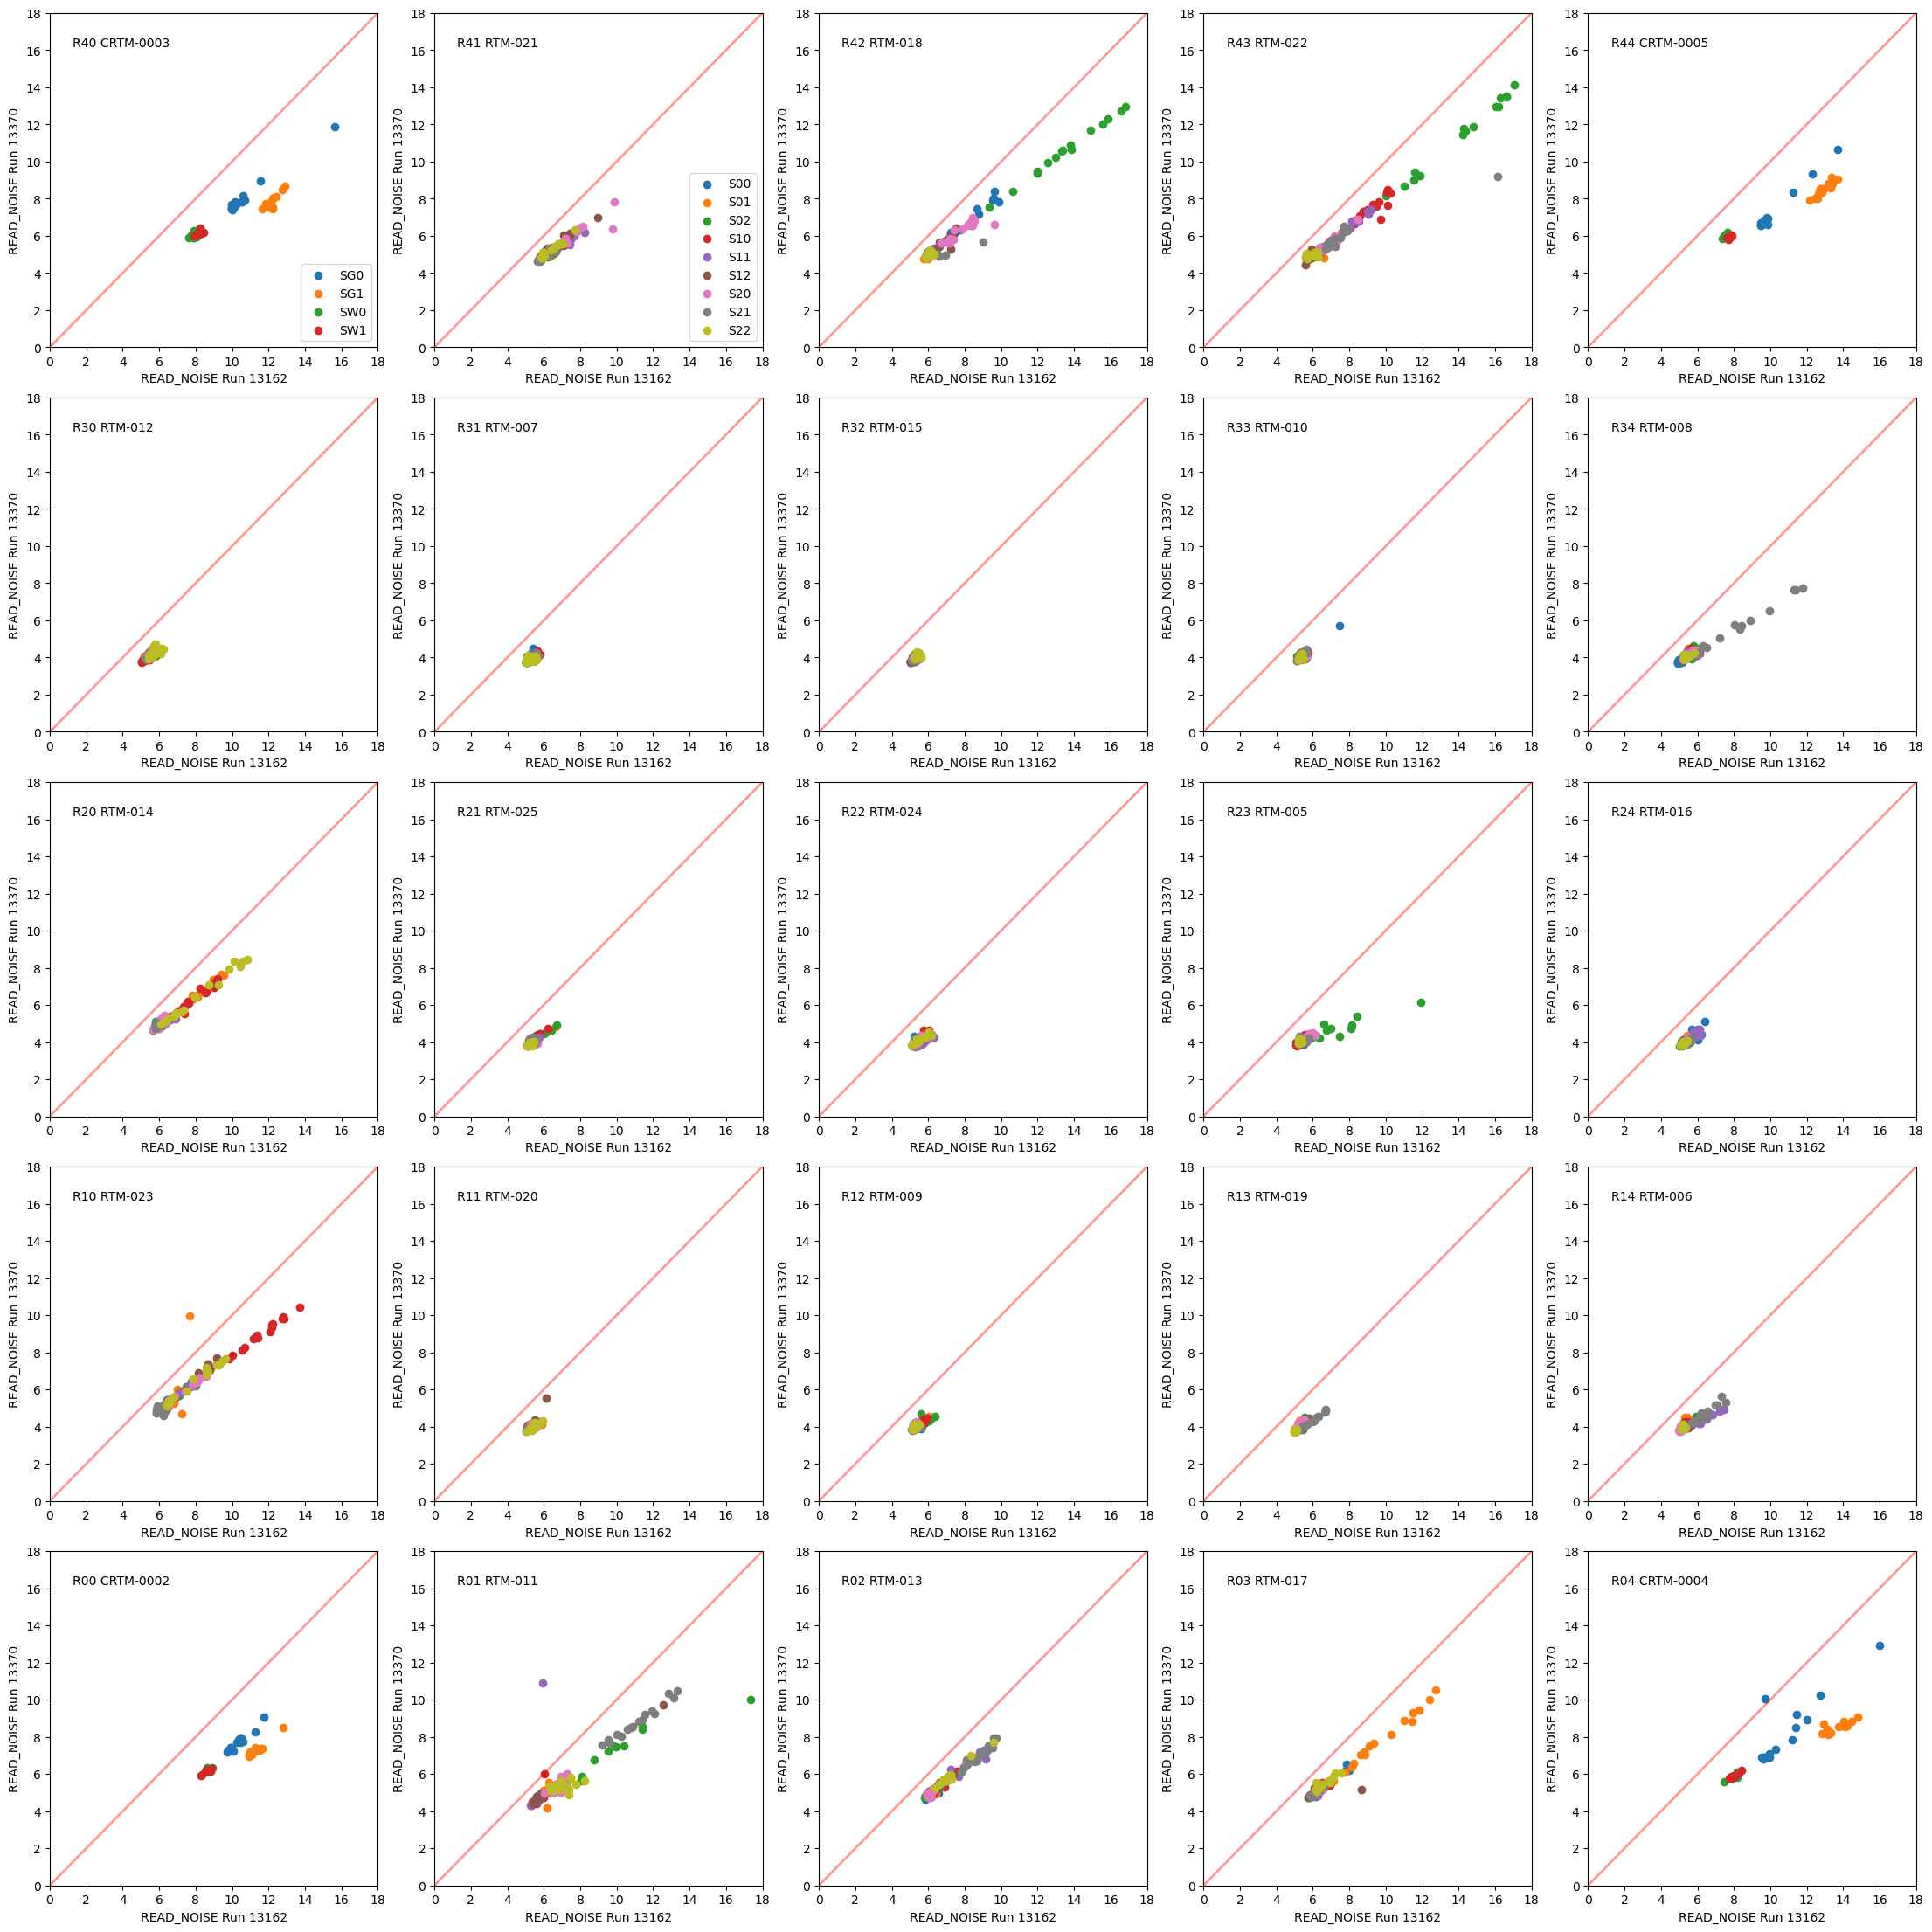

In [22]:
compare_tworuns(df_run5,df_13370,'13162','13370',quantity='READ_NOISE',minxy=0.0,maxxy=18.0)

## High Noise channels

In [52]:
highnoise = (df_13370.READ_NOISE>18.0)
print(tabulate(df_13370[highnoise][['BAY_SLOT','SEGMENT','READ_NOISE']],headers='keys',tablefmt='psql'))

+------+------------+-----------+--------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE |
|------+------------+-----------+--------------|
| 2704 | R40_SG1    | C10       |      87.9756 |
| 2861 | R41_S21    | C02       |     102.881  |
| 3124 | R43_S20    | C14       |     147.081  |
| 3181 | R44_SG0    | C02       |      67.5136 |
+------+------------+-----------+--------------+


In [55]:
lownoise = (df_13370.READ_NOISE<3.5)
print(tabulate(df_13370[lownoise][['BAY_SLOT','SEGMENT','READ_NOISE']],headers='keys',tablefmt='psql'))

+------------+-----------+--------------+
| BAY_SLOT   | SEGMENT   | READ_NOISE   |
|------------+-----------+--------------|
+------------+-----------+--------------+


# Dark Current

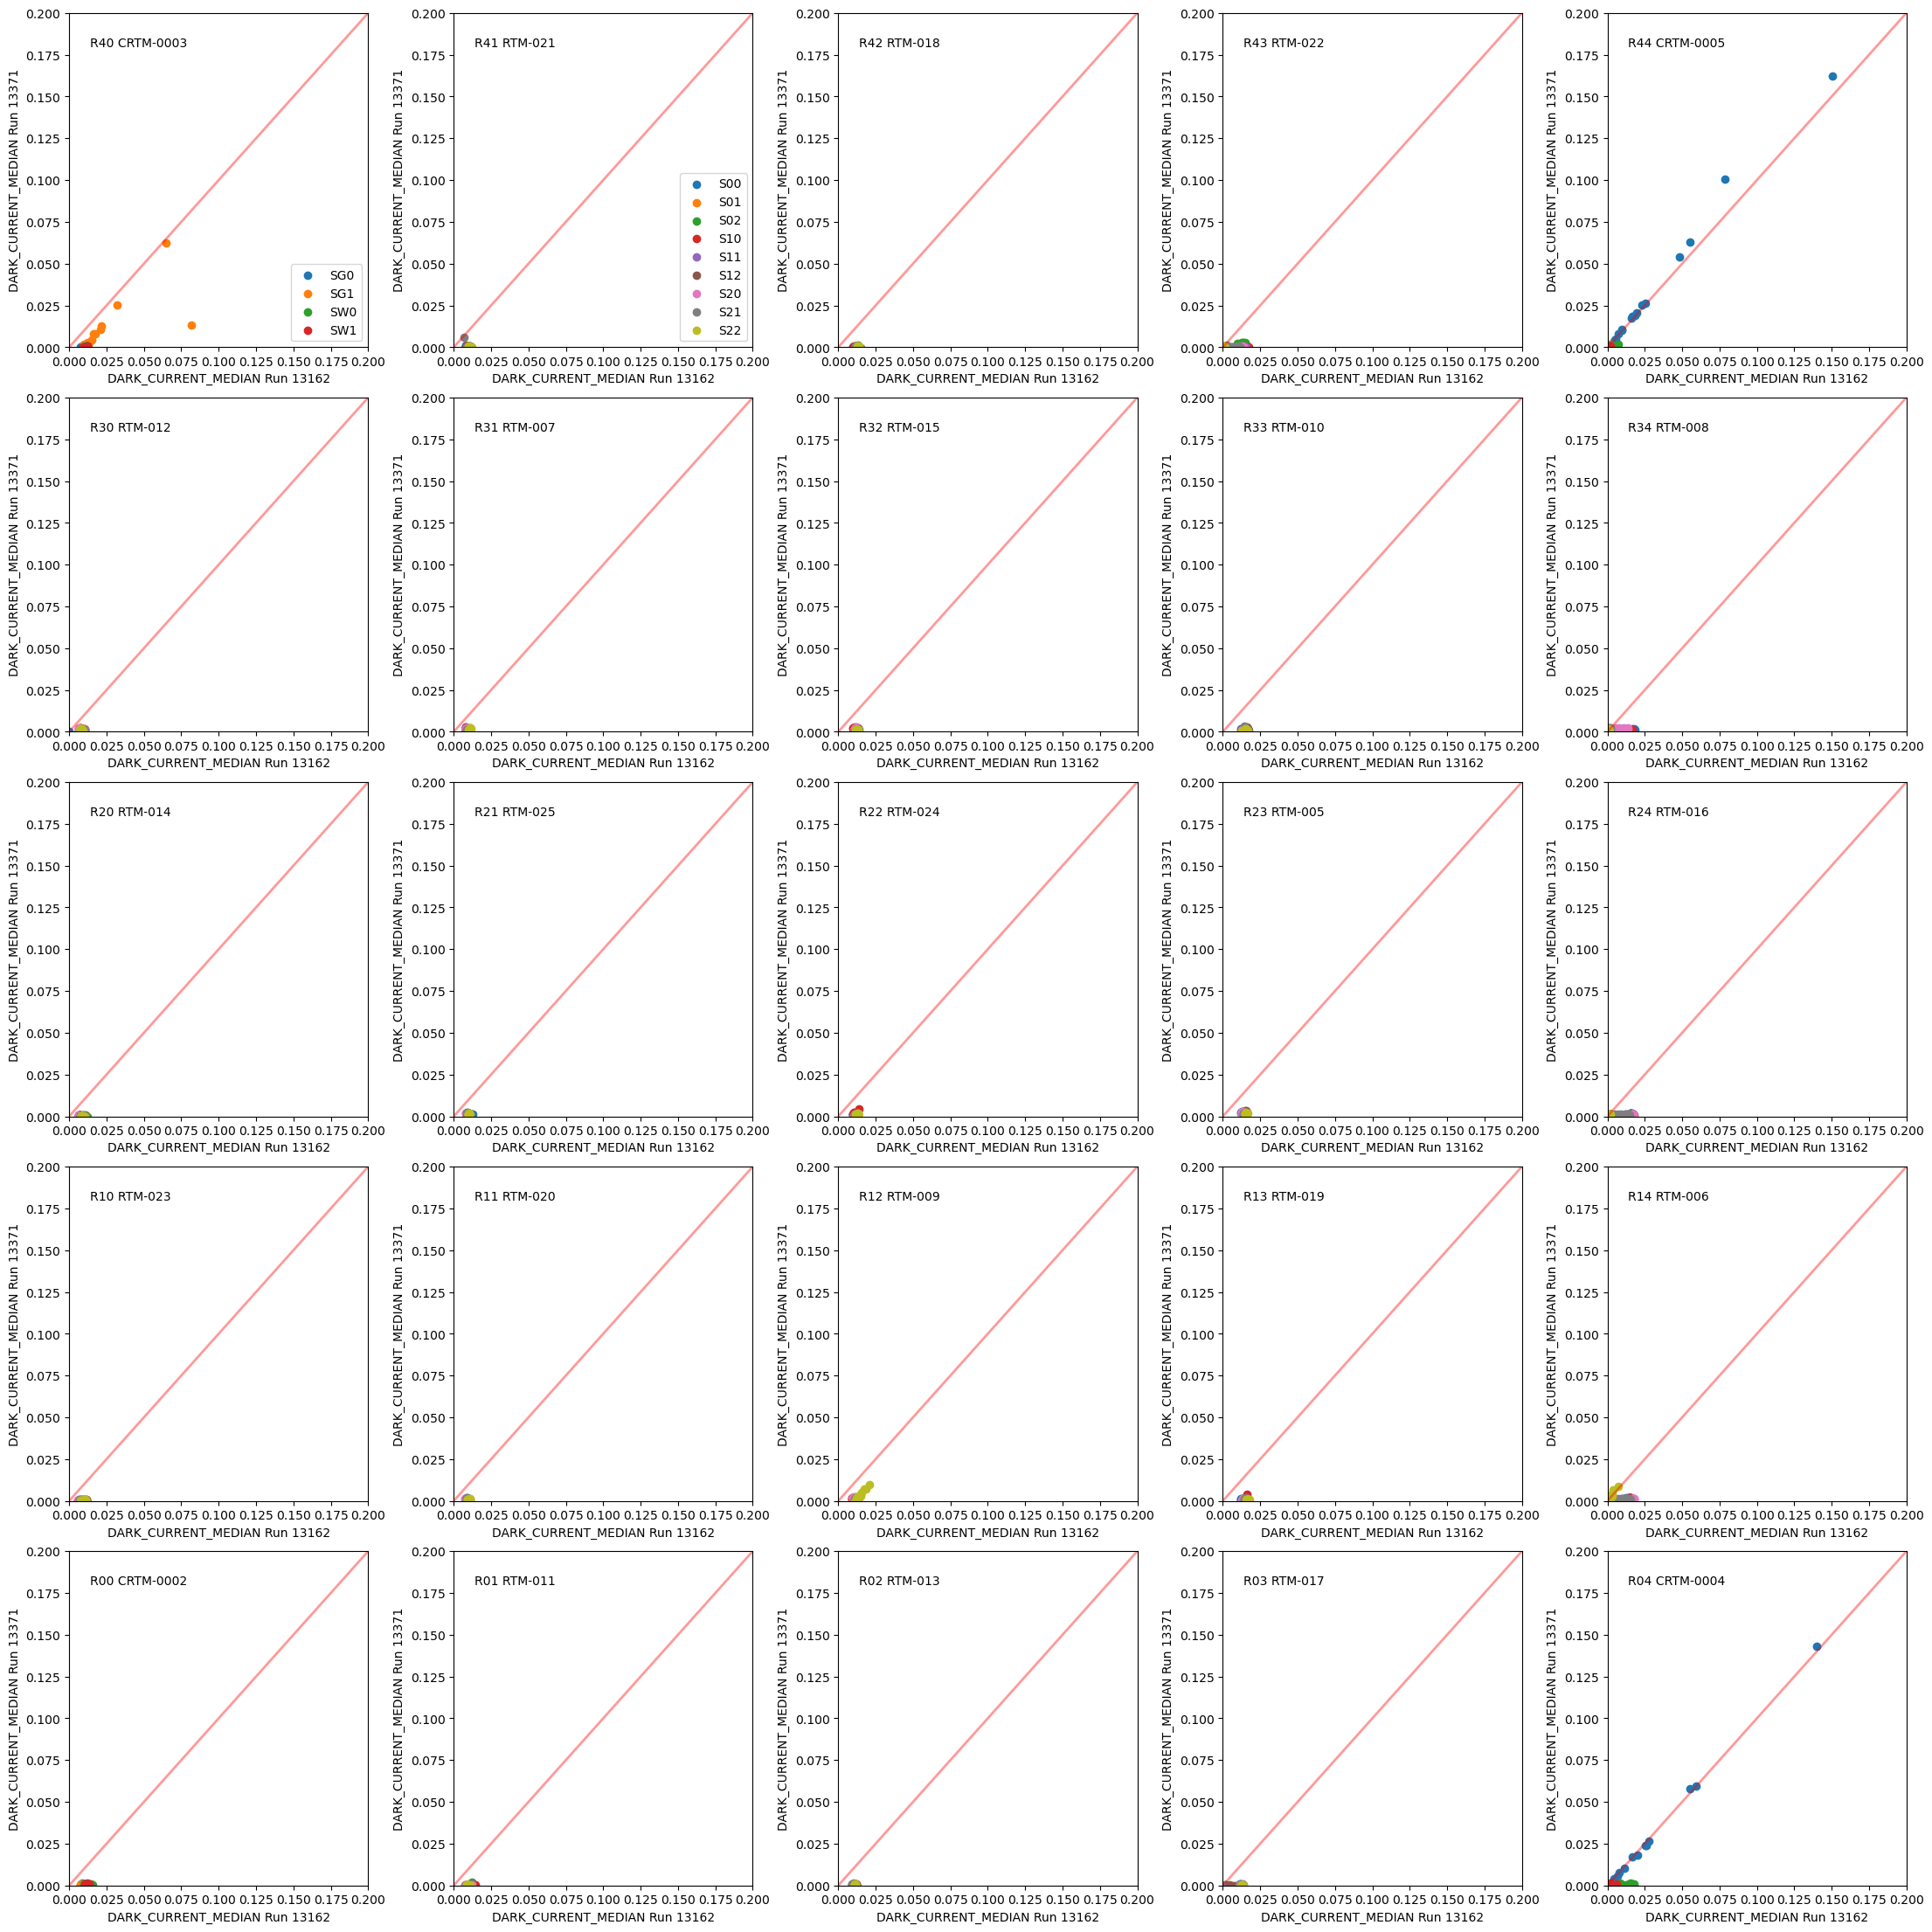

In [59]:
compare_tworuns(df_run5,df_13371,'13162','13371',quantity='DARK_CURRENT_MEDIAN',minxy=0.0,maxxy=0.2)

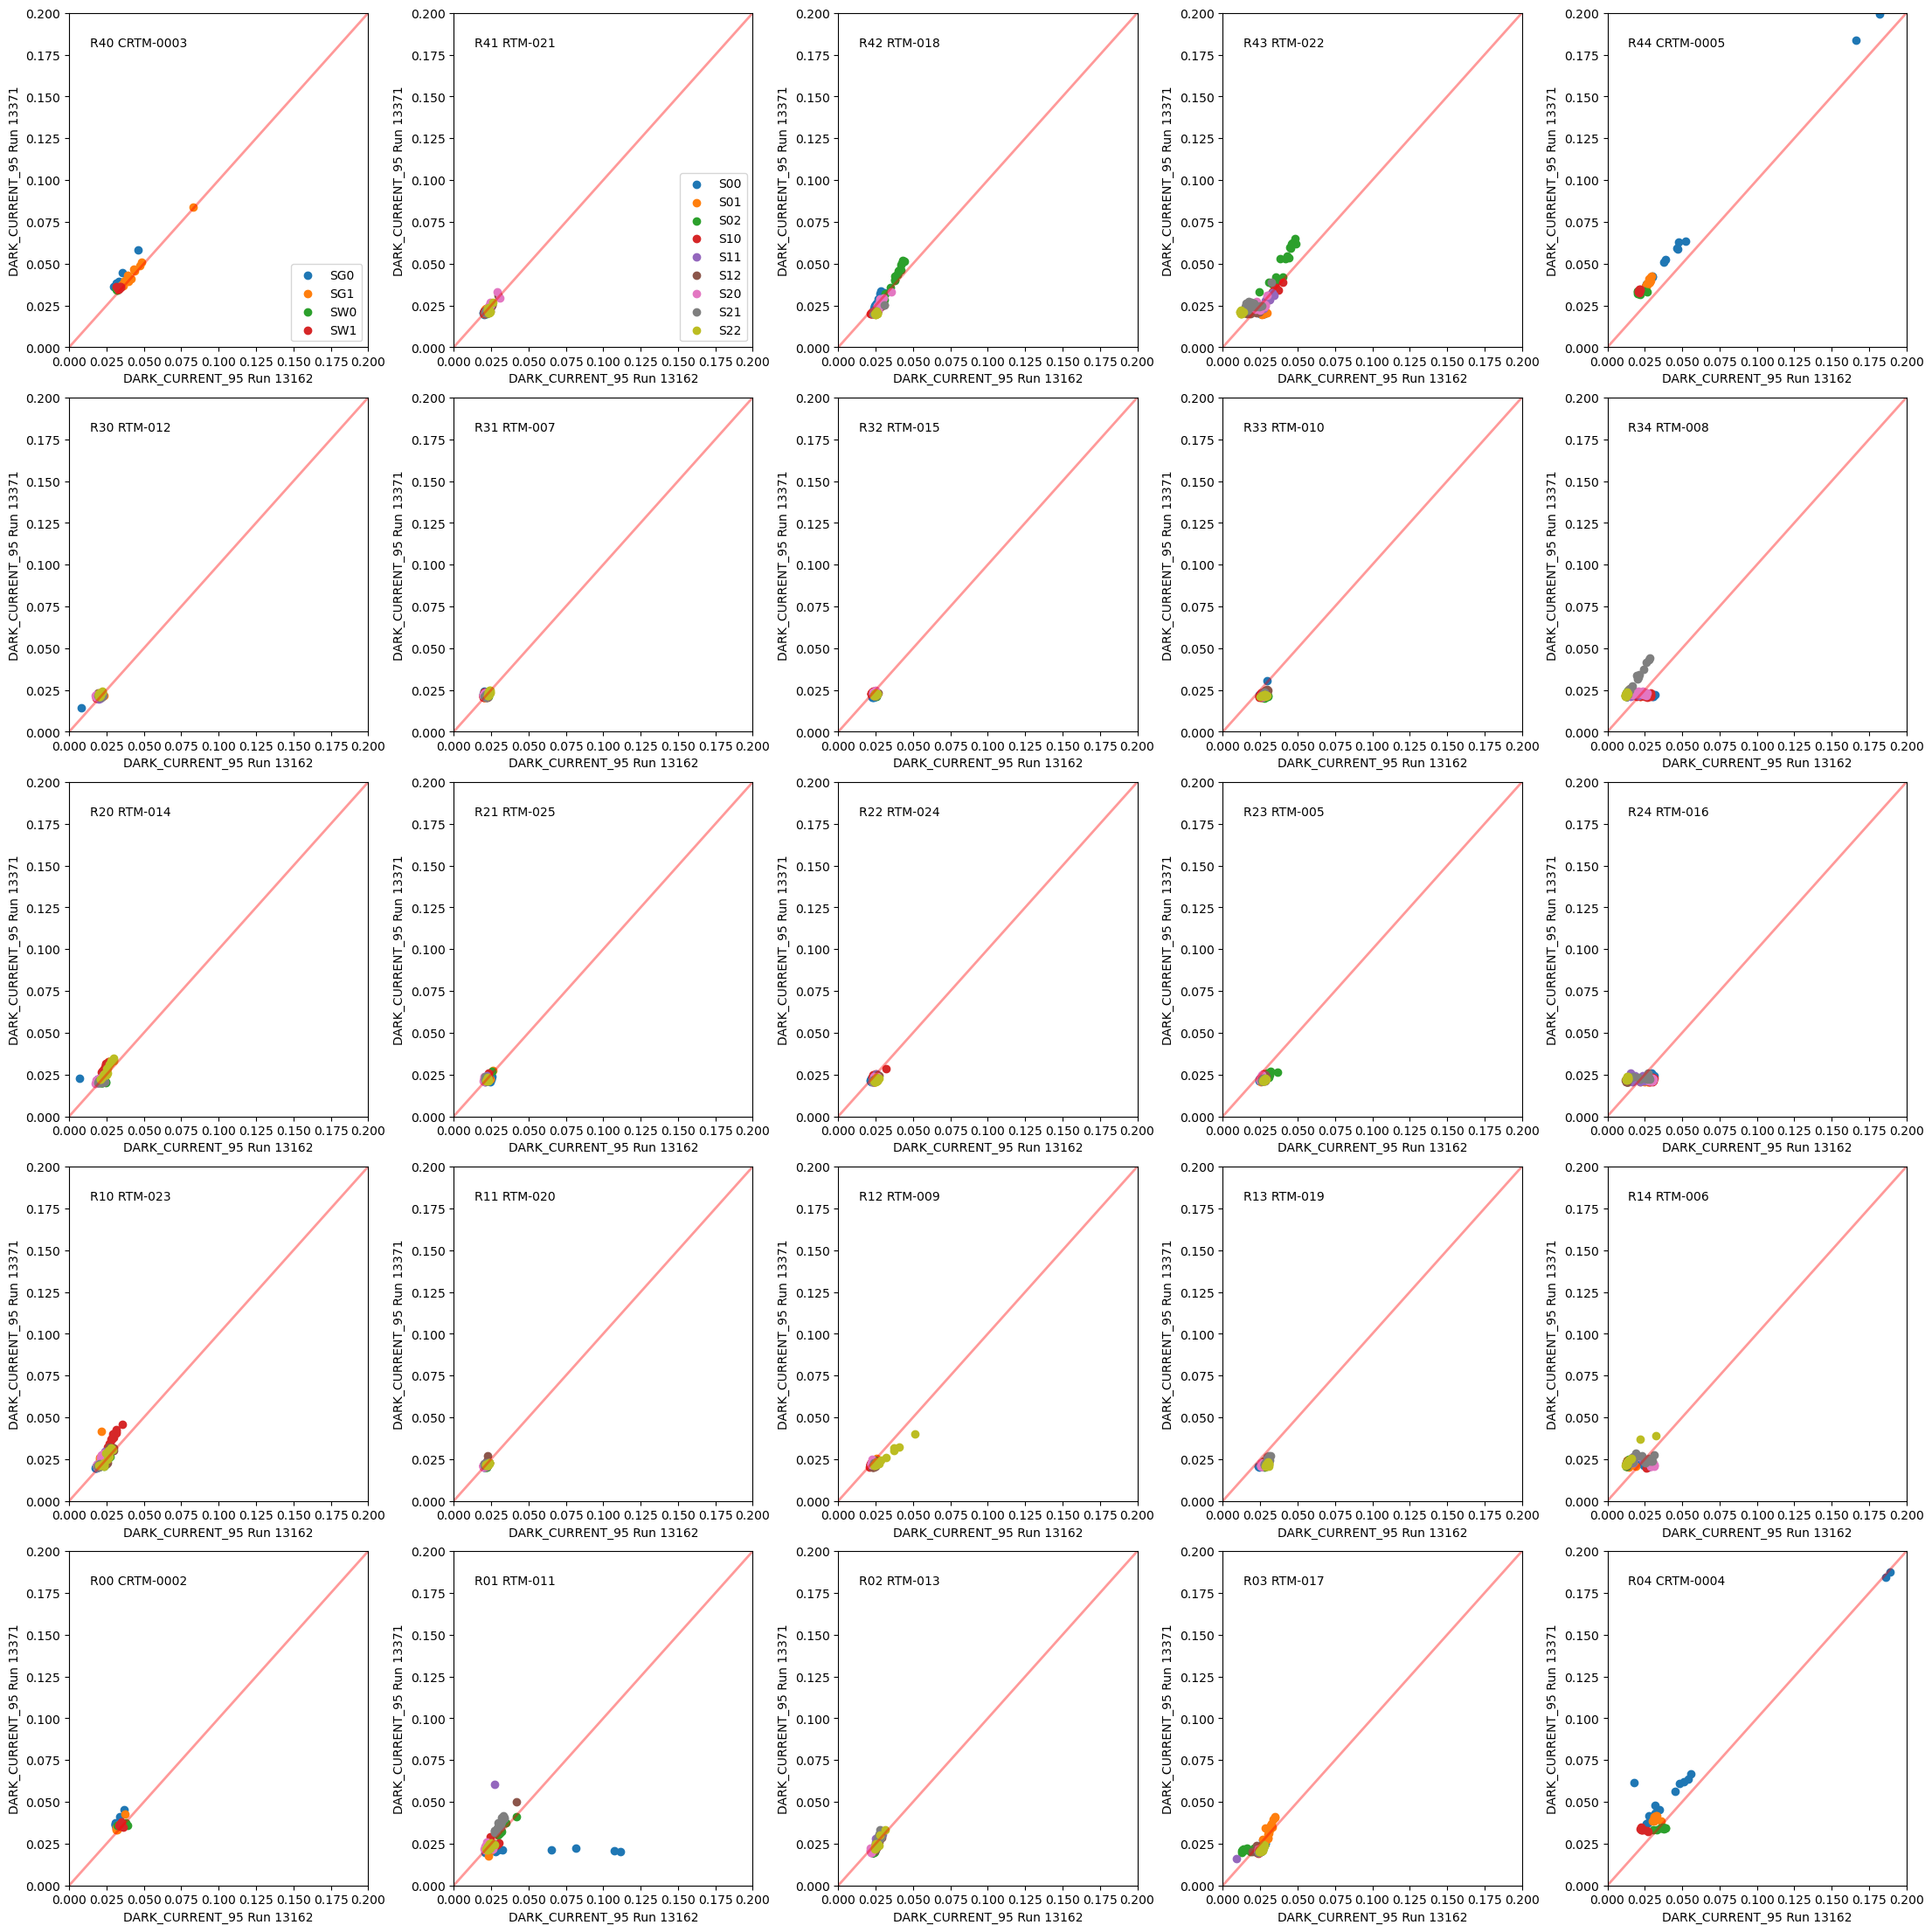

In [60]:
compare_tworuns(df_run5,df_13371,'13162','13371',quantity='DARK_CURRENT_95',minxy=0.0,maxxy=0.2)

## High Dark Current channels

In [61]:
highdarkcurrent = (df_13371.DARK_CURRENT_95>0.2)
print(tabulate(df_13371[highnoise][['BAY_SLOT','SEGMENT','DARK_CURRENT_MEDIAN','DARK_CURRENT_95']],headers='keys',tablefmt='psql'))

+------+------------+-----------+-----------------------+-------------------+
|      | BAY_SLOT   | SEGMENT   |   DARK_CURRENT_MEDIAN |   DARK_CURRENT_95 |
|------+------------+-----------+-----------------------+-------------------|
| 2704 | R40_SG1    | C10       |           0.013412    |          0.624617 |
| 2861 | R41_S21    | C02       |           0.00619493  |          0.362084 |
| 3124 | R43_S20    | C14       |           0.000212022 |          0.373549 |
| 3181 | R44_SG0    | C02       |           0.100423    |          1.05372  |
+------+------------+-----------+-----------------------+-------------------+


# Bias Stability

In [31]:
repo = '/repo/ir2'
runnum = 13370
weekly = 24
collections = ['u/lsstccs/eo_bias_stability_%d_w_2023_%d'%(runnum,weekly)]
butler = daf_butler.Butler(repo, collections=collections)
biasstab = {}
for i in range(205):
    biasstab[i] = butler.get('bias_stability_stats',detector=i)

In [32]:
biasstab[98].columns

Index(['run', 'exposure_id', 'mjd', 'det_name', 'amp_name', 'mean', 'stdev',
       'rc_mean', 'rc_stdev'],
      dtype='object')

In [34]:
df_98 = biasstab[98]
print(tabulate(df_98[(df_98.amp_name=='C10')],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))
print(len(df_98[(df_98.amp_name=='C10')]))

+-----+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------+
|     |   run |   exposure_id |       mjd | det_name   | amp_name   |   mean |   stdev |   rc_mean |   rc_stdev |
|-----+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------|
|   0 | 13370 | 3023061700148 | 60113.054 | R22_S22    | C10        |  0.246 |   3.504 |     0.342 |      3.509 |
|  16 | 13370 | 3023061700151 | 60113.054 | R22_S22    | C10        |  0.113 |   3.516 |     0.340 |      3.521 |
|  32 | 13370 | 3023061700155 | 60113.054 | R22_S22    | C10        |  0.212 |   3.538 |     0.404 |      3.539 |
|  48 | 13370 | 3023061700152 | 60113.054 | R22_S22    | C10        |  0.162 |   3.507 |     0.314 |      3.540 |
|  64 | 13370 | 3023061700153 | 60113.054 | R22_S22    | C10        |  0.193 |   3.507 |     0.309 |      3.553 |
|  80 | 13370 | 3023061700154 | 60113.054 | R22_S22    | C10        |  0.223 |   3.521 |

## Calculate bias stability RMS for all and rc

In [35]:
def get_segments(idet):
    seglist = []
    accd = camera[idet]
    for anamp in accd:
        seglist.append(anamp.getName())
    return seglist

In [36]:
def get_allrtmtype():
    rtm_type = {'R00':'corner','R01':'itl','R02':'itl','R03':'itl','R04':'corner',
                'R10':'itl','R11':'e2v','R12':'e2v','R13':'e2v','R14':'e2v',
                'R20':'itl','R21':'e2v','R22':'e2v','R23':'e2v','R24':'e2v',
                'R30':'e2v','R31':'e2v','R32':'e2v','R33':'e2v','R34':'e2v',
                'R40':'corner','R41':'itl','R42':'itl','R43':'itl','R44':'corner'}
    return rtm_type

def calc_biasstability_rms(biasstab):

    rtmtype = get_allrtmtype()
    
    bay_slot = []
    bay_type = []
    segment = []
    rms = []
    rc_rms = []
    for idet in det_names.keys():
        bayslot_name = det_names[idet]
        bay = bayslot_name[0:3]
            
        df_bayslot = biasstab[idet]
        
        for seg in get_segments(idet):            
            df_C = df_bayslot[(df_bayslot.amp_name==seg)]
            
            bay_slot.append(bayslot_name)
            bay_type.append(rtmtype[bay])
            segment.append(seg)
            rms.append(np.std(df_C['mean']))
            rc_rms.append(np.std(df_C['rc_mean']))           

    dbias = {}
    dbias['bay_slot'] = bay_slot
    dbias['type'] = bay_type
    dbias['segment'] = segment
    dbias['rms'] = rms
    dbias['rc_rms'] = rc_rms

    # fill 
    df = pd.DataFrame(dbias)
    df.columns = df.columns.str.upper()
    return df        

In [37]:
df_bias = calc_biasstability_rms(biasstab)

In [38]:
e2v = (df_bias.TYPE=='e2v')
itl = (df_bias.TYPE=='itl') 
corner = (df_bias.TYPE=='corner')

In [39]:
print(df_bias)

     BAY_SLOT    TYPE SEGMENT       RMS    RC_RMS
0     R01_S00     itl     C10  0.037046  0.075618
1     R01_S00     itl     C11  0.034217  0.055575
2     R01_S00     itl     C12  0.015950  0.060242
3     R01_S00     itl     C13  0.017310  0.042728
4     R01_S00     itl     C14  0.013924  0.066716
...       ...     ...     ...       ...       ...
3211  R44_SW1  corner     C13  0.024270  0.054956
3212  R44_SW1  corner     C14  0.014225  0.051493
3213  R44_SW1  corner     C15  0.019687  0.066986
3214  R44_SW1  corner     C16  0.016641  0.034549
3215  R44_SW1  corner     C17  0.025224  0.074359

[3216 rows x 5 columns]


Text(0.5, 0.98, 'Run 13370')

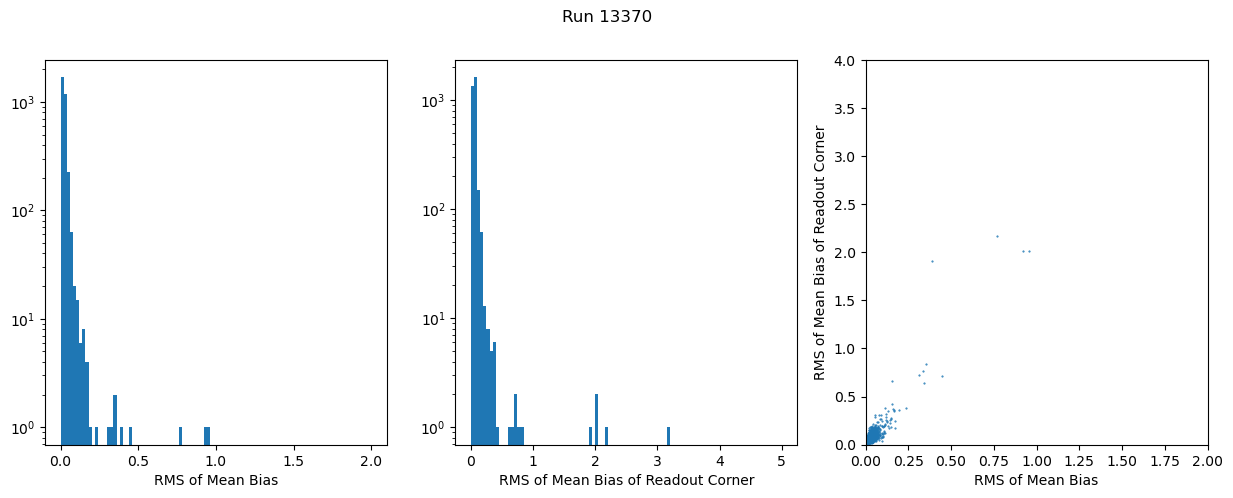

In [41]:
f,ax = plt.subplots(1,3,figsize=(15,5))
h = ax[0].hist(df_bias.RMS,bins=100,range=(0.,2.))
ax[0].set_xlabel('RMS of Mean Bias')
ax[0].set_yscale('log')

h = ax[1].hist(df_bias.RC_RMS,bins=100,range=(0.,5.))
ax[1].set_xlabel('RMS of Mean Bias of Readout Corner')
ax[1].set_yscale('log')

h = ax[2].scatter(df_bias.RMS,df_bias.RC_RMS,marker='.',s=1.)
ax[2].set_ylim(0.,4.)
ax[2].set_xlim(0.,2.)
ax[2].set_xlabel('RMS of Mean Bias')
ax[2].set_ylabel('RMS of Mean Bias of Readout Corner')
f.suptitle('Run %d'%(runnum))

In [45]:
# convert to amp_data format
def to_amp_data(df,name):
    
    outdict = {}
    for index, row in df.iterrows():
        if row.BAY_SLOT not in outdict:
            outdict[row.BAY_SLOT] = {}
            
        outdict[row.BAY_SLOT][row.SEGMENT] = row[name]
    return outdict

In [46]:
dict_rms = to_amp_data(df_bias,'RMS')
dict_rc_rms = to_amp_data(df_bias,'RC_RMS')

Text(0.5, 1.0, 'RMS of Mean Bias, Run 13370')

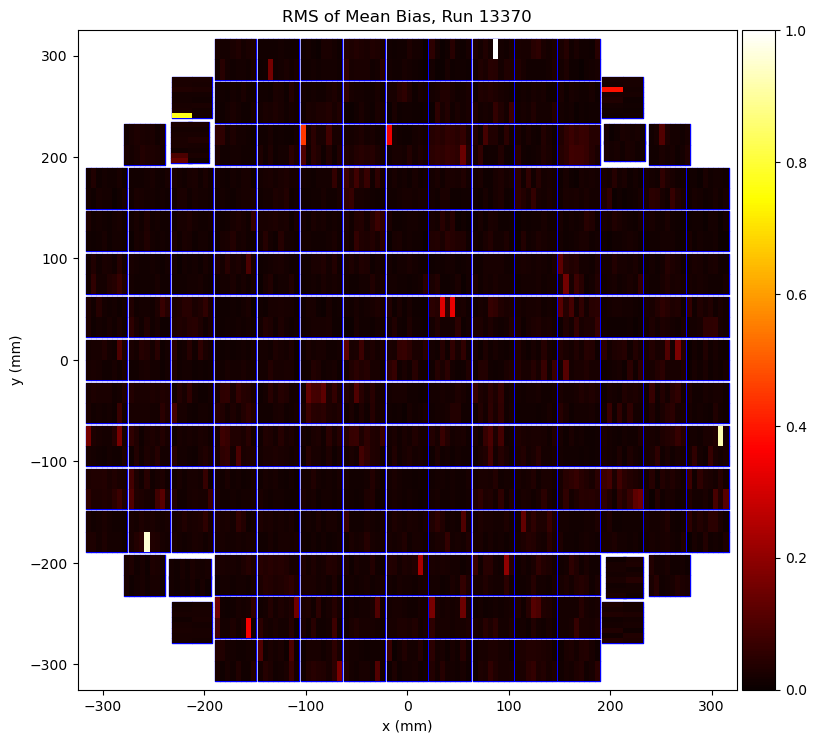

In [49]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, dict_rms, z_range=(0, 1.))
ax.set_title('RMS of Mean Bias, Run %d'%(runnum))

Text(0.5, 1.0, 'RMS of Mean Bias in Readout Corner, Run 13370')

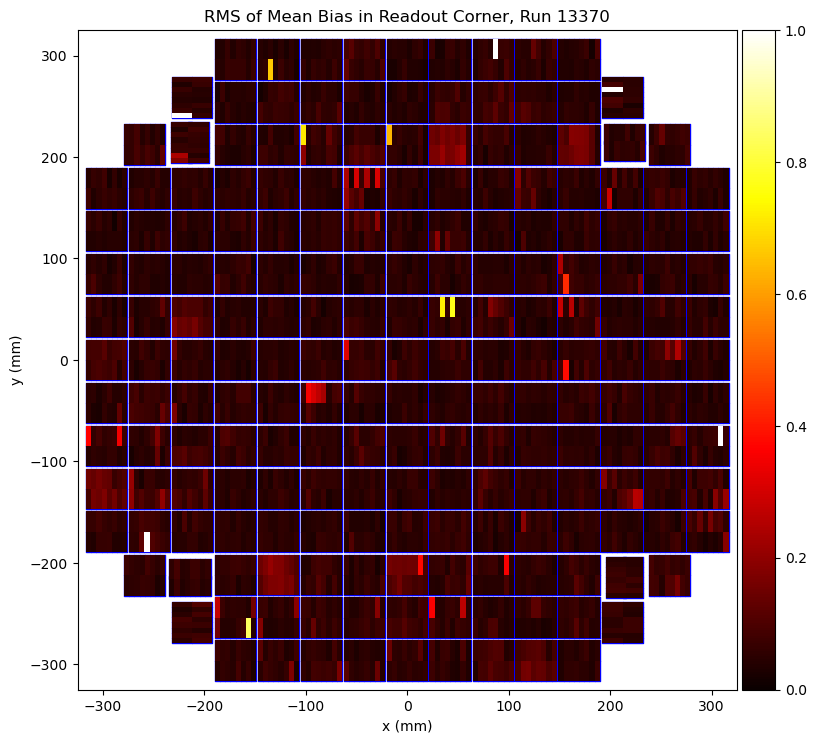

In [50]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, dict_rc_rms, z_range=(0, 1.))
ax.set_title('RMS of Mean Bias in Readout Corner, Run %d'%(runnum))